In [6]:
import pandas as pd
import numpy as np

data =  pd.read_csv("CEAS_08.csv")


In [7]:
print(data.isnull().sum())

sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64


In [8]:
# Fill missing values with a placeholder
data['receiver'].fillna('unknown_receiver', inplace=True)
data['subject'].fillna('no_subject', inplace=True)

C:\Users\Shubham Patil\AppData\Local\Temp\ipykernel_19268\3219517374.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['receiver'].fillna('unknown_receiver', inplace=True)
C:\Users\Shubham Patil\AppData\Local\Temp\ipykernel_19268\3219517374.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [9]:
print(data.isnull().sum())

sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64


In [10]:
# Extract domain from sender and receiver emails
def extract_domain(email):
    if isinstance(email, str) and '@' in email:
        return email.split('@')[-1]
    return 'unknown'

data['sender_domain'] = data['sender'].apply(extract_domain)
data['receiver_domain'] = data['receiver'].apply(extract_domain)

# Check if sender's email has suspicious keywords
def check_suspicious_sender(sender):
    suspicious_keywords = ['support', 'admin', 'helpdesk', 'secure']
    return int(any(keyword in sender.lower() for keyword in suspicious_keywords))

data['suspicious_sender'] = data['sender'].apply(check_suspicious_sender)


In [12]:
# Add length-based features
data['subject_length'] = data['subject'].apply(len)
data['body_length'] = data['body'].apply(len)

# Check for phishing-related keywords
phishing_keywords = ['urgent', 'verify', 'account', 'login', 'password']
def contains_phishing_keywords(text):
    return int(any(keyword in text.lower() for keyword in phishing_keywords))

data['subject_phishing_keywords'] = data['subject'].apply(contains_phishing_keywords)
data['body_phishing_keywords'] = data['body'].apply(contains_phishing_keywords)


In [14]:
# Define a function to extract URL features
def extract_url_features(url):
    if isinstance(url, str):
        # URL length
        url_length = len(url)
        # Check for suspicious keywords
        suspicious_keywords = ['login', 'verify', 'update', 'secure', 'account']
        has_suspicious_keywords = int(any(keyword in url.lower() for keyword in suspicious_keywords))
    else:
        url_length = 0
        has_suspicious_keywords = 0
    
    return pd.Series([url_length, has_suspicious_keywords])

# Apply the function to the 'urls' column
data[['url_length', 'suspicious_keywords']] = data['urls'].apply(extract_url_features)


In [15]:
# Select features for the model
features = [
    'suspicious_sender', 'subject_length', 'body_length',
    'subject_phishing_keywords', 'body_phishing_keywords',
    'url_length', 'suspicious_keywords'
]
X = data[features]

# Target variable
y = data['label']


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (31323, 7), (31323,)
Testing set: (7831, 7), (7831,)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [19]:
# Initialize Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)


In [20]:
# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [21]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Confusion matrix for a detailed view
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8986080960286043

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      3490
           1       0.91      0.91      0.91      4341

    accuracy                           0.90      7831
   macro avg       0.90      0.90      0.90      7831
weighted avg       0.90      0.90      0.90      7831


Confusion Matrix:
 [[3085  405]
 [ 389 3952]]


In [23]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Accuracy of Best Model:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Accuracy of Best Model: 0.9192951091814583
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3490
           1       0.92      0.93      0.93      4341

    accuracy                           0.92      7831
   macro avg       0.92      0.92      0.92      7831
weighted avg       0.92      0.92      0.92      7831



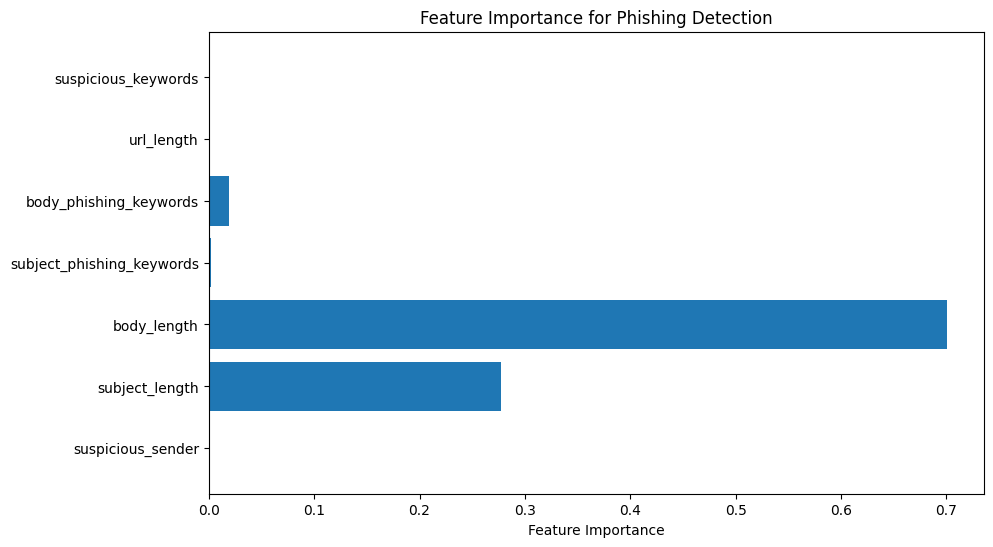

In [24]:
import matplotlib.pyplot as plt

# Get feature importance from the Random Forest model
feature_importances = best_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Phishing Detection")
plt.show()


In [25]:
import joblib

# Save the trained model
joblib.dump(best_model, 'phishing_email_detector.pkl')


['phishing_email_detector.pkl']